<a href="https://colab.research.google.com/github/dsid271/Basic-Object-Detection-System/blob/main/en_hi_Te_transformer_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install WordPiece

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for WordPiece: filename=wordpiece-0.0.0-py3-none-any.whl size=1745 sha256=fa334281936ef7393940e63e29b1ed4c5d1a5a8c32f9f2b08be517a3e67b7f07
  Stored in directory: /root/.cache/pip/wheels/a7/07/52/27946dee94359e93d98b96e72cd87d8761b7dc54fae797ef6d
Successfully built WordPiece


In [1]:
pip install datasets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import random
import gc

In [3]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


In [4]:
dataset1 = load_dataset("opus100", "en-hi")
df1_train = pd.DataFrame(dataset1['train']['translation'],columns=['en','hi'])
df1_train.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_val = pd.DataFrame(dataset1['validation']['translation'],columns=['en','hi'])
df1_val.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_test = pd.DataFrame(dataset1['test']['translation'],columns=['en','hi'])
df1_test.rename(columns={'en':'lang1','hi':'lang2'},inplace=True)
df1_train['lang2_id'] = 'hi'
df1_val['lang2_id'] = 'hi'
df1_test['lang2_id'] = 'hi'

dataset2 = load_dataset("opus100", "en-te")
df2_train = pd.DataFrame(dataset2['train']['translation'],columns=['en','te'])
df2_train.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_val = pd.DataFrame(dataset2['validation']['translation'],columns=['en','te'])
df2_val.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_test = pd.DataFrame(dataset2['test']['translation'],columns=['en','te'])
df2_test.rename(columns={'en':'lang1','te':'lang2'},inplace=True)
df2_train['lang2_id'] = 'te'
df2_val['lang2_id'] = 'te'
df2_test['lang2_id'] = 'te'
train_df = pd.concat([df1_train,df2_train]).reset_index(drop=True)
val_df = pd.concat([df1_val,df2_val]).reset_index(drop=True)
test_df = pd.concat([df1_test,df2_test]).reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/534319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/64352 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [5]:
train_df

,lang1,lang2,lang2_id
0,"Other, Private Use","अन्य, निज़ी उपयोग",hi
1,[SCREAMING],ऊबड़ .,hi
2,Spouse,जीवनसाथी,hi
3,I will never salute you!,- तुम एक कमांडर कभी नहीं होगा!,hi
4,and the stars and the trees bow themselves;,और तारे और वृक्ष सजदा करते है;,hi
...,...,...,...
598666,Sad life.,సాడ్ జీవితం.,te
598667,Are you taking your driver's test drunk?,మీరు మీ డ్రైవర్ యొక్క పరీక్ష తాగిన తీసుకున్నట...,te
598668,Initiate recall.,రీకాల్ ప్రారంభించు.,te
598669,No. You need to come see me right now.,నంఇప్పుడేచూడండిమీరు రావాలి.,te


In [6]:
len(train_df), len(val_df), len(test_df)

(598671, 4000, 4000)

In [7]:
full_df = pd.concat([train_df,val_df])
lang1,lang2 = list(full_df['lang1']), list(full_df['lang2'])
full = lang1+lang2
random.shuffle(full)

bert_tokenizer = Tokenizer(WordPiece(unk_token="<unk>"))
bert_tokenizer.normalizer = normalizers.Sequence([Lowercase()])
bert_tokenizer.pre_tokenizer = Whitespace()
bert_tokenizer.decoder = decoders.WordPiece()
trainer = WordPieceTrainer(special_tokens=["<unk>","<pad>","<s-en>","<s-hi>","<s-te>","</s>"])
bert_tokenizer.train_from_iterator(full,trainer)
bert_tokenizer.enable_padding(
    pad_id=bert_tokenizer.token_to_id('<pad>'),
    length=128,
    pad_token='<pad>'
)
bert_tokenizer.enable_truncation(128)

base = Path('translator/tokenizer',)
base.mkdir(exist_ok=True,parents=True)
bert_tokenizer.save(str(base / 'en_hi_te.json'))

In [8]:
x = bert_tokenizer.encode(f"<s-hi>{lang2[12345]}</s>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')

print('\n',bert_tokenizer.decode(x.ids),'\n\n')

x = bert_tokenizer.encode(f"<s-te>{lang2[-111]}</s>")
for a,b in zip(x.ids, x.tokens):
    if b!= '<pad>':
        print(f'{a} : {b}')

print('\n',bert_tokenizer.decode(x.ids))

3 : <s-hi>
5058 : आपने
8860 : चैनल
3695 : मालिक
969 : का
23556 : विशेषाधिकार
10 : %
22 : 1
933 : से
2837 : वापस
1172 : ले
1616 : लिया
897 : है
19 : .
5 : </s>

 आपने चैनल मालिक का विशेषाधिकार % 1 से वापस ले लिया है. 


4 : <s-te>
55 : l
10142 : అతనికి
17550 : వ్యవ
5374 : ##సా
507 : ##య
2076 : నా
4086 : వా
4885 : ##టా
2526 : వి
10364 : ##క్ర
13918 : ##యిం
4463 : ##చి
1814 : ##ంది
19 : .
5 : </s>

 l అతనికి వ్యవసాయ నా వాటా విక్రయించింది.


In [9]:
print('en',bert_tokenizer.token_to_id('<s-en>'))
print('hi',bert_tokenizer.token_to_id('<s-hi>'))
print('te',bert_tokenizer.token_to_id('<s-te>'))
print('eos',bert_tokenizer.token_to_id('</s>'))
print('pad',bert_tokenizer.token_to_id('<pad>'))

en 2
hi 3
te 4
eos 5
pad 1


In [10]:
class Dataset:
    def __init__(self,df):
        self.df = df
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        en,lang2 = sample['lang1'], sample['lang2']
        start_token = "<s-hi>" if sample['lang2_id']=='hi' else "<s-te>"
        en = bert_tokenizer.encode(f'<s-en>{en.strip()}</s>').ids
        l2 = bert_tokenizer.encode(f'{start_token}{lang2.strip()}</s>').ids
        l2_shift = l2.copy()
        l2_shift[:-1] = l2[1:]
        l2_shift[-1] = bert_tokenizer.token_to_id('<pad>')

        en = torch.tensor(en,dtype=torch.long)
        l2 = torch.tensor(l2,dtype=torch.long)
        l2_shift = torch.tensor(l2_shift,dtype=torch.long)
        l2_shift[l2_shift==1]=-100
        return en,l2,l2_shift

In [11]:
train_ds = Dataset(train_df)
val_ds = Dataset(val_df)

In [12]:
print('english tokens\n',train_ds[0][0])
print('lang2 tokens\n',train_ds[0][1])
print('right-shifted lang2 tokens\n',train_ds[0][2])

english tokens
 tensor([   2, 1716,   17, 7303, 2171,    5,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])
lang2 tokens
 tensor([   3, 3372,   17, 1048, 3302, 2934,    5,    1,    1,    1,    1,    1,
           1,    1,    1,    1,  

In [13]:
# https://github.com/bzhangGo/rmsnorm/blob/master/rmsnorm_torch.py
class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed


class MultiheadAttention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.):
        super().__init__()
        self.dim = dim
        self.n_heads = n_heads
        assert dim % n_heads == 0, 'dim should be div by n_heads'
        self.head_dim = self.dim // self.n_heads
        self.q = nn.Linear(dim,dim,bias=False)
        self.k = nn.Linear(dim,dim,bias=False)
        self.v = nn.Linear(dim,dim,bias=False)
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = self.head_dim ** -0.5
        self.out_proj = nn.Linear(dim,dim,bias=False)

    def forward(self,q,k,v,mask=None):
        batch,t,c = q.shape
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        q = q.view(batch,q.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        k = k.view(batch,k.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)
        v = v.view(batch,v.size(1),self.n_heads,self.head_dim).permute(0,2,1,3)

        qkT = torch.matmul(q,k.transpose(-1,-2)) * self.scale
        qkT = self.attn_dropout(qkT)

        if mask is not None:
            mask = mask.to(dtype=qkT.dtype,device=qkT.device)
            a,b = qkT.size(-2), qkT.size(-1)
            qkT = qkT.masked_fill(mask[:,:,:a,:b]==0,float('-inf'))

        qkT = F.softmax(qkT,dim=-1)

        attn = torch.matmul(qkT,v)
        attn = attn.permute(0,2,1,3).contiguous().view(batch,t,c)
        out = self.out_proj(attn)
        return out



class FeedForward(nn.Module):
    def __init__(self,dim,dropout=0.):
        super().__init__()
        self.feed_forward = nn.Sequential(
            nn.Linear(dim,dim*4,bias=False),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(dim*4,dim,bias=False)
        )

    def forward(self, x):
        return self.feed_forward(x)



class EncoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ffd = FeedForward(dim,mlp_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)

    def forward(self,x,mask=None):
        x = self.ln_1(x)
        x = x + self.attn(x,x,x,mask)
        x = self.ln_2(x)
        x = x + self.ffd(x)
        return x



class DecoderBlock(nn.Module):
    def __init__(self, dim, n_heads, attn_dropout=0., mlp_dropout=0.):
        super().__init__()
        self.self_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.cross_attn = MultiheadAttention(dim,n_heads,attn_dropout)
        self.ln_1 = RMSNorm(dim)
        self.ln_2 = RMSNorm(dim)
        self.ln_3 = RMSNorm(dim)
        self.ffd = FeedForward(dim,mlp_dropout)

    def forward(self, x, enc_out, src_mask, tgt_mask):
        x = self.ln_1(x)
        x = x + self.self_attn(x,x,x,tgt_mask)
        x = self.ln_2(x)
        x = x + self.cross_attn(x,enc_out,enc_out,src_mask) # decoder: q, encoder: k,v
        x = self.ln_3(x)
        x = x + self.ffd(x)

        return x



class Embedding(nn.Module):
    def __init__(self,vocab_size,max_len,dim):
        super().__init__()
        self.max_len = max_len
        self.class_embedding = nn.Embedding(vocab_size,dim)
        self.pos_embedding = nn.Embedding(max_len,dim)
    def forward(self,x):
        x = self.class_embedding(x)
        pos = torch.arange(0,x.size(1),device=x.device)
        x = x + self.pos_embedding(pos)
        return x



class Seq2SeqTransformer(nn.Module):
    def __init__(self, config):

        super().__init__()

        self.embedding = Embedding(config['vocab_size'],config['max_len'],config['dim'])

        self.depth = config['depth']
        self.encoders = nn.ModuleList([
            EncoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])
        self.decoders = nn.ModuleList([
            DecoderBlock(
                dim=config['dim'],
                n_heads=config['n_heads'],
                attn_dropout=config['attn_dropout'],
                mlp_dropout=config['mlp_dropout']
            ) for _ in range(self.depth)
        ])

        self.ln_f = RMSNorm(config['dim'])
        self.lm_head = nn.Linear(config['dim'],config['vocab_size'],bias=False)

        self.embedding.class_embedding.weight = self.lm_head.weight

        self.pad_token_id = config['pad_token_id']
        self.register_buffer('tgt_mask',torch.tril(torch.ones(1,1,config['max_len'],config['max_len'])))

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def create_src_mask(self,src):
        return (src != self.pad_token_id).unsqueeze(1).unsqueeze(2) # N, 1, 1, src_len

    def forward(self, src, tgt, labels=None):

        src_mask = self.create_src_mask(src)

        enc_out = self.embedding(src)
        dec_out = self.embedding(tgt)

        for i in range(self.depth):
            enc_out = self.encoders[i](enc_out,mask=src_mask)
            dec_out = self.decoders[i](dec_out,enc_out,src_mask=src_mask,tgt_mask=self.tgt_mask)

        dec_out = self.ln_f(dec_out)

        if labels is not None:
            lm_logits = self.lm_head(dec_out)
            loss = F.cross_entropy(lm_logits.view(-1, lm_logits.shape[-1]), labels.view(-1))
            return loss

        lm_logits = self.lm_head(dec_out[:,[-1],:])
        return lm_logits

    def generate(self,src,max_tokens=80,temperature=1.0,deterministic=False,eos=5,bos=None):
        tgt = torch.ones(1,1).long() * bos
        tgt = tgt.to(src.device)
        for _ in range(max_tokens):
            out = self(src,tgt)
            out = out[:,-1,:] / temperature
            probs = F.softmax(out,dim=-1)
            if deterministic:
                next_token = torch.argmax(probs,dim=-1,keepdim=True)
            else:
                next_token = torch.multinomial(probs,num_samples=1)
            tgt = torch.cat([tgt,next_token],dim=1)
            if next_token.item() == eos:
                break

        return tgt.cpu().flatten()

In [14]:
config = {
    'dim': 128,
    'n_heads': 4,
    'attn_dropout': 0.1,
    'mlp_dropout': 0.1,
    'depth': 8,
    'vocab_size': bert_tokenizer.get_vocab_size(),
    'max_len': 128,
    'pad_token_id': bert_tokenizer.token_to_id('<pad>')
}
config

{'dim': 128,
 'n_heads': 4,
 'attn_dropout': 0.1,
 'mlp_dropout': 0.1,
 'depth': 8,
 'vocab_size': 30000,
 'max_len': 128,
 'pad_token_id': 1}

In [15]:
model = Seq2SeqTransformer(config).to('cuda')
print(sum([p.numel() for p in model.parameters() if p.requires_grad]))

7531648


In [16]:
print(model)

Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 128)
    (pos_embedding): Embedding(128, 128)
  )
  (encoders): ModuleList(
    (0-7): 8 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=128, out_features=128, bias=False)
        (k): Linear(in_features=128, out_features=128, bias=False)
        (v): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=128, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (self_attn): Mul

In [17]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128,shuffle=True,pin_memory=True,num_workers=2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=128,shuffle=False,pin_memory=True,num_workers=2)
print(len(train_dl), len(val_dl))

4678 32


In [18]:
test_samples = [(test_df.loc[i,'lang1'],test_df.loc[i,'lang2'],test_df.loc[i,'lang2_id']) for i in range(len(test_df))]

In [19]:
epochs = 5
train_losses = []
valid_losses = []
best_val_loss = 1e9

all_tl = []
all_lr = []

optim = torch.optim.Adam(model.parameters(),lr=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=250,
    eta_min=1e-8
)

scaler = GradScaler()

In [20]:
for ep in tqdm(range(epochs)):
    model.train()
    trl = 0.
    tprog = tqdm(enumerate(train_dl),total=len(train_dl))
    for i, batch in tprog:
        with autocast():
            src, tgt, labels = [b.to('cuda') for b in batch]
            loss = model(src,tgt,labels)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            optim.zero_grad()
            sched.step(ep + i / len(train_dl))
            all_lr.append(sched.get_last_lr())
            trl += loss.item()
            all_tl.append(loss.item())
            tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl/len(train_dl))

    gc.collect()
    torch.cuda.empty_cache()

    model.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl),total=len(val_dl))
        for i, batch in vprog:
            with autocast():
                src, tgt, labels = [b.to('cuda') for b in batch]
                loss = model(src,tgt,labels)
                vrl += loss.item()
                vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl/len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')

        if vloss < best_val_loss:
            best_val_loss = vloss

            print('saving best model...')
            sd = model.state_dict()
            torch.save(sd,'./translator/best_model.pt')

        print('saving epoch checkpoint...')
        sd = model.state_dict()
        torch.save(sd,f'./translator/checkpoint_model_epoch{ep}.pt')

        print('predicting with current epoch model...')
        for (src,tgt,lang_id) in random.choices(test_samples,k=5):
            input_ids = bert_tokenizer.encode(f"<s-en>{src}</s>").ids
            input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')
            if lang_id == 'hi':
                bos = bert_tokenizer.token_to_id('<s-hi>')
            else:
                bos = bert_tokenizer.token_to_id('<s-te>')
            tgt_out = model.generate(input_ids,bos=bos,deterministic=True)
            tgt_out = bert_tokenizer.decode(tgt_out.numpy())
            print(f'\nEN: {src} \n{lang_id.upper()}: {tgt} \n{lang_id.upper()}_MODEL: {tgt_out}\n')

        print('-'*30,'\n\n')

    gc.collect()
    torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 0 | train_loss: 5.4873 valid_loss: 5.1057
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: I'm sorry, I'll never do this again. 
TE: నేను విచారిస్తున్నాను , నేను మళ్ళీ దీన్ని ఎప్పటికీ. 
TE_MODEL: నేను నేను నేను ఒక ఒక ఒక ఒక ఒక ఒక ఒక ఒక ఒక ఉంది.


EN: Y Start Scale 
TE: Y ప్రారంభపు కొలమానం 
TE_MODEL: 1


EN: Title 
TE: శీర్షిక 
TE_MODEL: @ info :


EN: Thanks. 
TE: ధన్యవాదాలు. 
TE_MODEL: మీరు.


EN: Attachment Reminder 
HI: संलग्नक स्मारक 
HI_MODEL: चयनित कार्य

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 1 | train_loss: 3.9917 valid_loss: 4.4810
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: but I won 50 G in a poker tournament. 
TE: కానీ నేను ఒక పోకర్ టోర్నమెంట్ను 50 G గెలిచింది. 
TE_MODEL: కానీ నేను ఒక ఒక ఒక ఒక ఒక ఒక ఒక ఒక పర్ర్ర్ర్ర్ర్ర్ర్లు.


EN: Three dead and two were our guys. 
TE: చనిపోయిన మూడు మరియు రెండు మా అబ్బాయిలు,. 
TE_MODEL: రెండు మరియు మా మా మా మా మా ఉంది.


EN: _Countdown 
TE: లెక్కింపును వాడు (_C) 
TE_MODEL: సక్స్name


EN: Hey, Malcolm, I didn't know you worked at Kmart, and apparently the hair on top of your head didn't know it, either. 
TE: హే, మాల్కం, నేను మీరు K మార్ట్ పని తెలుసా, మరియు స్పష్టంగా మీ తల పైన జుట్టు గాని, అది తెలియదు. 
TE_MODEL: హే, నేను మీరు నా తల్లి, మీరు మీ మీ మీ మీ మీ తల్లి, మరియు మీ మీ మీ తల్లి, మరియు మీరు ఒక ఒక ఒక ఒక ఒక ఒక ఒక ఒక ఒక ఒక ఒక వ్యక్తి లేదు.


EN: - What? 
TE: - ఏం? 
TE_MODEL: - ఏమి?

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 2 | train_loss: 3.3096 valid_loss: 4.1191
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: Up 
TE: పైకి@ action 
TE_MODEL: @ info


EN: St_op Animation 
HI: संजीवन रोकें (_o) 
HI_MODEL: स्वतः चल रहा है वे हमेशा ( _h )


EN: Constraints the panning to an axis 
HI: प्रतिबन्ध किसी अक्ष को पैन करने के लिए 
HI_MODEL: अक्ष पर ब अक्ष पर विराजमान हुआ


EN: - It'; getting hot in here 
TE: - ఇది ఇక్కడ వేడి పెరిగిపోతుంది 
TE_MODEL: - ఇది ఇక్కడ ఇక్కడ ఉంది


EN: Right 
HI: दायाँ 
HI_MODEL: ठीक है

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 3 | train_loss: 2.8454 valid_loss: 3.8981
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: Let me get there first and check it out. 
TE: నాకు ముందుగా పొందుటకు మరియు దాన్ని తనిఖీ లెట్. 
TE_MODEL: నాకు ఇక్కడ మరియు ఇక్కడ బయటకు బయటకు పొందుటకు.


EN: And then I let-- Oh, for the last time, what happened to Mowgli? 
TE: చివరిసారి, ఏమి మోగ్లీ జరిగింది? 
TE_MODEL: మరియు నేను చివరికికికికికికికికి, ఏమి జరిగింది?


EN: Like he was two different people. 
HI: की तरह वह दो अलग अलग लोगों को था. 
HI_MODEL: जैसे वह दोनों दोनों से अलग था.


EN: DOKE: 
HI: DOKE: 
HI_MODEL: - अप :


EN: I had an MRI once and the nurse talked me through the whole thing, so do you mind doing that? 
HI: मैं एक एमआरआई एक बार किया था और नर्स ने मुझे पूरी बात के माध्यम से बात की, तो आप ऐसा कर बुरा नहीं? 
HI_MODEL: मैं एक बार और एक बार मुझे बात की बात की थी, मुझे बता दिया था, तो आप अपने मन में बात कर रहे हैं?

------------------------------ 




  0%|          | 0/4678 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

epoch 4 | train_loss: 2.5083 valid_loss: 3.7693
saving best model...
saving epoch checkpoint...
predicting with current epoch model...

EN: Now you take it down and lead it round in front of the guests. 
TE: ఇప్పుడు మీరు రాసికొను మరియు అతిధుల ముందు రౌండ్ దారి. అది అంటే. 
TE_MODEL: ఇప్పుడు మీరు డౌన్ డౌన్ మరియు అది ఆ ఆ ఆ శత్రువు యొక్క వదులుము.


EN: And to you We have revealed the Book containing the truth, confirming the earlier revelations, and preserving them (from change and corruption). So judge between them by what has been revealed by God, and do not follow their whims, side-stepping the truth that has reached you. To each of you We have given a law and a way and a pattern of life. If God had pleased He could surely have made you one people (professing one faith). But He wished to try and test you by that which He gave you. So try to excel in good deeds. To Him will you all return in the end, when He will tell you of what you were at variance. 
HI: और हमने तुम्हारी ओर यह किताब हक़

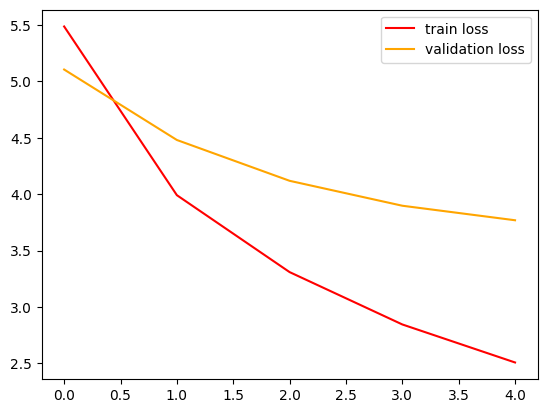

In [21]:
plt.plot(train_losses,color='red',label='train loss')
plt.plot(valid_losses,color='orange',label='validation loss')
plt.legend()
plt.show()

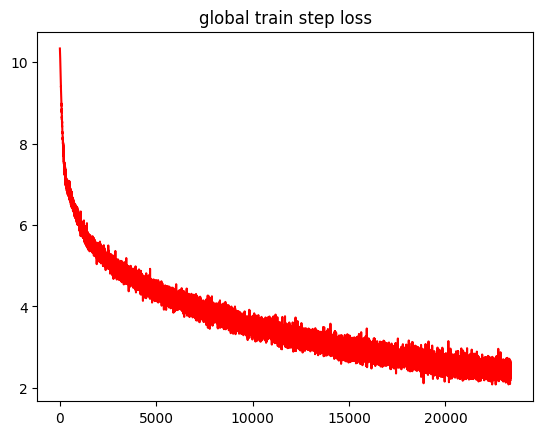

In [22]:
plt.plot(all_tl,color='red')
plt.title('global train step loss')
plt.show()

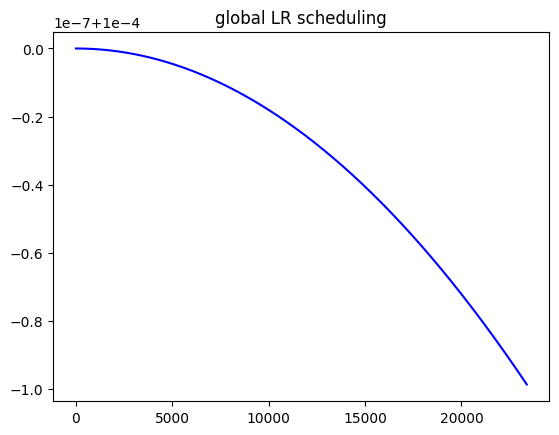

In [23]:
plt.plot(all_lr,color='blue')
plt.title('global LR scheduling')
plt.show()

In [24]:
sd = torch.load('./translator/best_model.pt')
model.load_state_dict(sd)
model.eval()

Seq2SeqTransformer(
  (embedding): Embedding(
    (class_embedding): Embedding(30000, 128)
    (pos_embedding): Embedding(128, 128)
  )
  (encoders): ModuleList(
    (0-7): 8 x EncoderBlock(
      (attn): MultiheadAttention(
        (q): Linear(in_features=128, out_features=128, bias=False)
        (k): Linear(in_features=128, out_features=128, bias=False)
        (v): Linear(in_features=128, out_features=128, bias=False)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ffd): FeedForward(
        (feed_forward): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=False)
          (1): Dropout(p=0.1, inplace=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=128, bias=False)
        )
      )
      (ln_1): RMSNorm()
      (ln_2): RMSNorm()
    )
  )
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (self_attn): Mul

In [25]:
with torch.no_grad():
    for i, (src,tgt,lang_id) in enumerate(random.choices(test_samples,k=250)):
        input_ids = bert_tokenizer.encode(f"<s-en>{src}</s>").ids
        input_ids = torch.tensor(input_ids,dtype=torch.long).unsqueeze(0).to('cuda')
        deterministic = False
        if i > 125:
            deterministic = True
        if lang_id == 'hi':
            bos = bert_tokenizer.token_to_id('<s-hi>')
        else:
            bos = bert_tokenizer.token_to_id('<s-te>')
        if not deterministic:
            temperature = np.random.uniform(0.8,1.2,(1,))[0]
        else:
            temperature = 1.0
        tgt_out = model.generate(input_ids,temperature=temperature,deterministic=deterministic,bos=bos)
        tgt_out = bert_tokenizer.decode(tgt_out.numpy())
        print(f'{deterministic=}, {temperature=:.3f}')
        print(f'\nEN: {src} \n{lang_id.upper()}: {tgt} \n{lang_id.upper()}_MODEL: {tgt_out}\n\n')

deterministic=False, temperature=0.970

EN: - We're friends in need -And friends in need 
TE: మేమునిజానికిఅవసరం మరియు స్నేహితులతో స్నేహితులు 
TE_MODEL: - మేము స్నేహితులు _findgys अन्कार पैसे की जरूरत है


deterministic=False, temperature=0.994

EN: Remove current view of the document 
HI: हटाएँ का दस्तावेज़ 
HI_MODEL: दस्तावेज की किस दृश्य हटाएँ


deterministic=False, temperature=0.809

EN: Font 
HI: फ़ॉन्ट 
HI_MODEL: फ़ॉन्ट


deterministic=False, temperature=0.884

EN: It's been here forever. It's empty. 
TE: - సంఖ్య ఇది, బ్రో. 
TE_MODEL: ఇది రోజులఉంటే.


deterministic=False, temperature=0.902

EN: Scientific 
HI: वैज्ञानिक 
HI_MODEL: वैज्ञानिक


deterministic=False, temperature=1.114

EN: They will surely perish who kill their offspring in ignorance foolhardily, and forbid the food that God has given them by fabricating lies against God. Misguided are they surely, and will never come to guidance. 
HI: बेशक जिन लोगों ने अपनी औलाद को बे समझे बूझे बेवकूफी से मार डाला और जो रोज़ी ख़ुदा ने 